In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir='/content/drive/MyDrive/summer intern/dataset/train'

In [4]:
test_data_dir='/content/drive/MyDrive/summer intern/dataset/test'

In [5]:
img_height,img_width=224,224
img_path=data_dir+'/0/1.png'
img=image.load_img(img_path,target_size=(img_height,img_width))
img_data=image.img_to_array(img)
img_data=np.expand_dims(img_data,axis=0)
img_data=preprocess_input(img_data)

In [6]:
classes=[str(i) for i in range(6)]

In [7]:
val_data_dir='/content/drive/MyDrive/summer intern/dataset/valid'

In [8]:
train_images_per_class=500

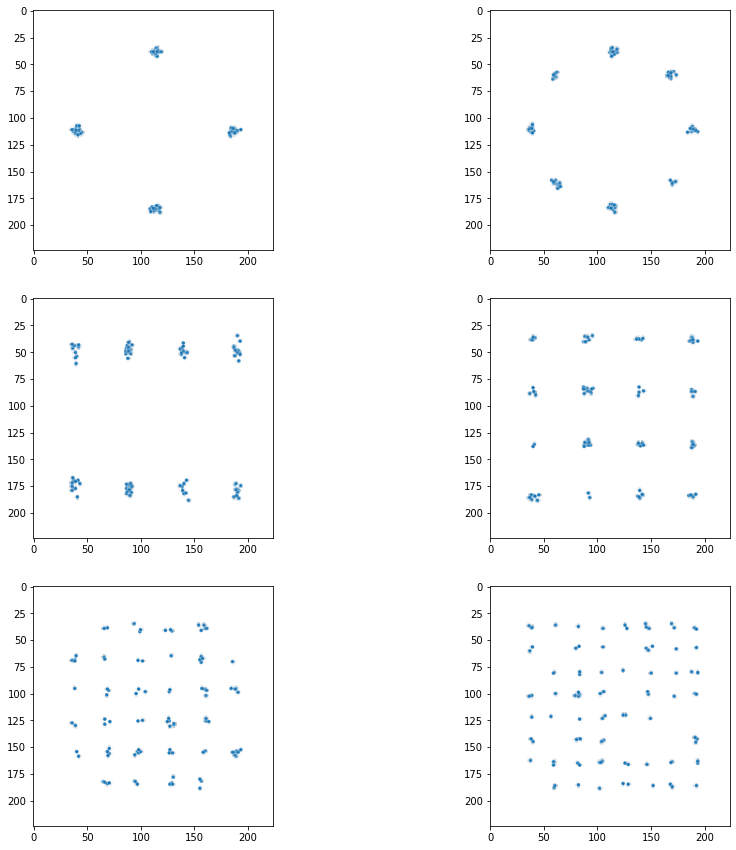

In [9]:
from matplotlib import pyplot as plt
from PIL import Image
 
# Opens a image in RGB mode
newsize=(224,224)

sample_imgs=[17,21,12,8,0,6]
imgs=[]
for i in range(6):
  imgs.append(Image.open("/content/drive/MyDrive/summer intern/dataset/train/"+str(i)+'/'+str(sample_imgs[i])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 3
columns = 2


for i in range(6):
  # Adds a subplot at the ith position
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(imgs[i])

  
# showing image

In [10]:
def gen_circle(img: np.ndarray, center: tuple, diameter: int,fill_val: int) -> np.ndarray:
  
    """
        Creates a matrix of ones filling a circle.
    """

    # gets the radius of the image
    radius  = diameter//2

    # gets the row and column center of the image
    row, col = center 

    # generates theta vector to variate the angle
    theta = np.arange(0, 360)*(np.pi/180)

    # generates the indexes of the column
    y = (radius*np.sin(theta)).astype("int32") 

    # generates the indexes of the rows
    x = (radius*np.cos(theta)).astype("int32") 

    # with:
    # img[x, y] = 1
    # you can draw the border of the circle 
    # instead of the inner part and the border. 

    # centers the circle at the input center
    rows = x + (row)
    cols  = y + (col)

    # gets the number of rows and columns to make 
    # to cut by half the execution
    nrows = rows.shape[0] 
    ncols = cols.shape[0]

    # makes a copy of the image
    img_copy = np.copy(img)

    # We use the simetry in our favour
    # does reflection on the horizontal axes 
    # and in the vertical axes

    for row_down, row_up, col1, col2 in zip(rows[:nrows//4],
                            np.flip(rows[nrows//4:nrows//2]),
                            cols[:ncols//4],
                            cols[nrows//2:3*ncols//4]):
    
        img_copy[row_up:row_down, col2:col1] = fill_val

 
    return img_copy

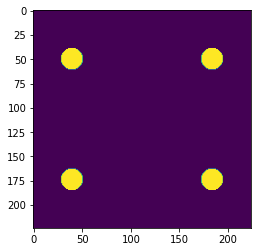

In [11]:
# R filter
#four concentric circles - centres
diam = 25
x_dis=40
y_dis=50
r_filter_dim=[(y_dis,x_dis),(224-y_dis,x_dis),(y_dis,224-x_dis),(224-y_dis,224-x_dis)]

fil=np.zeros((224,224),dtype=int)
for i in range(4):
  fil=gen_circle(fil,r_filter_dim[i],diam,1)
plt.imshow(fil)

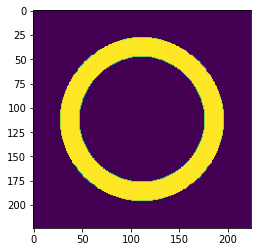

In [12]:
# G filter

# ring-outer radius and inner radius
g_filter_dim=[85,65]
val=[1,0]
fil=np.zeros((224,224),dtype=int)
for i in range(2):
  fil=gen_circle(fil,(112,112),2*g_filter_dim[i],val[i])
plt.imshow(fil)

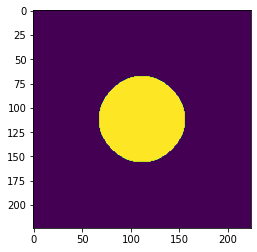

In [13]:
# B filter

# circle-diameter
b_filter_dim=90

fil=np.zeros((224,224),dtype=int)
fil=gen_circle(fil,(112,112),b_filter_dim,1)
plt.imshow(fil)

In [14]:
def apply_filter(im):
  center = (112,112)

  #red layer filter 
  fil=np.zeros((224,224),dtype=int)
  for i in range(4):
    fil=gen_circle(fil,r_filter_dim[i],diam,1)
  im[:,:,0]=im[:,:,0]*fil

  #blue layer filter
  fil=np.zeros((224,224),dtype=int)
  g_filter_dim=[85,65]
  val=[1,0]
  fil=np.zeros((224,224),dtype=int)
  for i in range(2):
    fil=gen_circle(fil,center,2*g_filter_dim[i],val[i])
  im[:,:,1]=im[:,:,1]*fil


  #blue layer filter
  fil=np.zeros((224,224),dtype=int)
  fil=gen_circle(fil,center,b_filter_dim,1)
  im[:,:,2]=im[:,:,2]*fil
  
  return im

In [15]:
def disp_filter_image(im):
  im=apply_filter(im)
  plt.imshow(im)
  plt.axis('off')

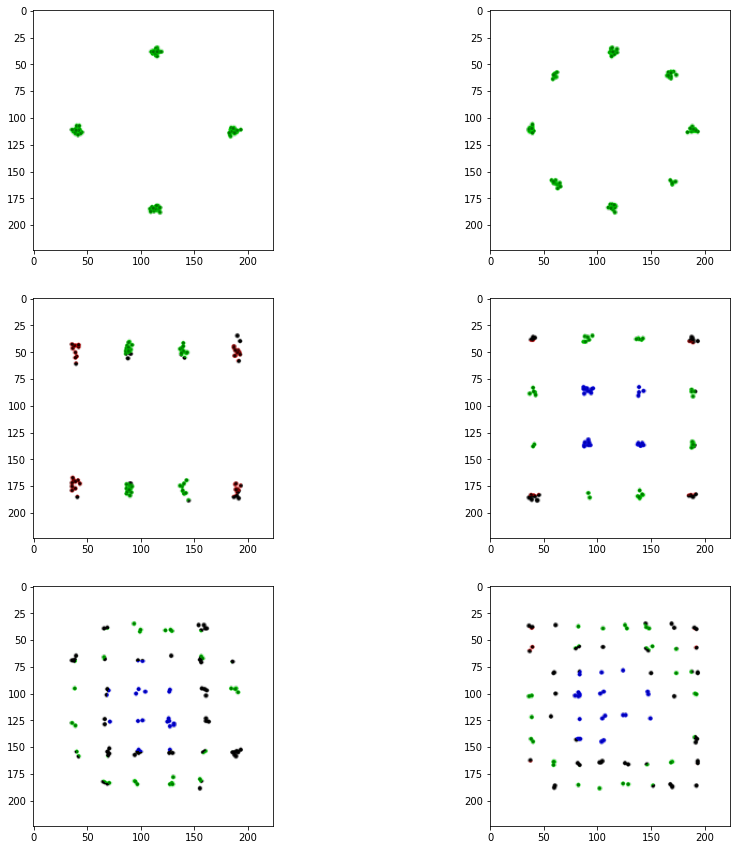

In [16]:
fil_imgs=[]
for i in range(6):
  fil_imgs.append(Image.open("/content/drive/MyDrive/summer intern/dataset/train/"+str(i)+'/'+str(sample_imgs[i])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 3
columns = 2

for i in range(6):
  # Adds a subplot at the ith position
  fil_imgs[i]=apply_filter(np.array(fil_imgs[i]))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(fil_imgs[i])

In [17]:
train_data=[]
train_label=[]
img_height,img_width=224,224
for cls in classes:
  print(cls)
  for i in range(500):
    img_path=data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=image.img_to_array(img)
    train_data.append(img_data)
    train_label.append(int(cls))


0
1
2
3
4
5


In [18]:
train_label[:2*train_images_per_class]=[0]*2*train_images_per_class
train_label[2*train_images_per_class:]=[1]*4*train_images_per_class

In [19]:
valid_images_per_class=100

In [20]:
valid_data=[]
valid_label=[]
img_height,img_width=224,224
for cls in classes:
  print(cls)
  for i in range(100):
    img_path=val_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=image.img_to_array(img)
    valid_data.append(img_data)
    valid_label.append(int(cls))


0
1
2
3
4
5


In [21]:
valid_label=[]
valid_label[:2*valid_images_per_class]=[0]*2*valid_images_per_class
valid_label[2*valid_images_per_class:]=[1]*4*valid_images_per_class

In [22]:
train_data=np.asarray(train_data)
train_label=np.asarray(train_label)

In [23]:
valid_data=np.asarray(valid_data)
valid_label=np.asarray(valid_label)

In [24]:
for i in range(len(train_label)):
  train_data[i]=apply_filter(train_data[i])

In [25]:
for i in range(len(valid_label)):
  valid_data[i]=apply_filter(valid_data[i])

In [26]:
def preprocess_data(X,Y,n):
  X_p=preprocess_input(X)
  Y_p=tf.keras.utils.to_categorical(Y,n)
  return (X_p,Y_p)

In [27]:
train_data,train_label=preprocess_data(train_data,train_label,2)

In [28]:
valid_data,valid_label=preprocess_data(valid_data,valid_label,2)

In [29]:
print(train_data.shape,train_label.shape)

(3000, 224, 224, 3) (3000, 2)


In [30]:
resnet_model = Sequential()
input_t=tf.keras.Input(shape=(224,224,3))
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_tensor=input_t,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [31]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [32]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [33]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_data,train_label, validation_data=(valid_data,valid_label),batch_size=32, epochs=25,verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
94/94 [==============================] - 36s 224ms/step - loss: 3.7265 - accuracy: 0.7643 - val_loss: 0.2872 - val_accuracy: 0.8833
Epoch 2/25
94/94 [==============================] - 16s 172ms/step - loss: 0.3237 - accuracy: 0.8617 - val_loss: 0.2863 - val_accuracy: 0.8583
Epoch 3/25
94/94 [==============================] - 13s 137ms/step - loss: 0.2966 - accuracy: 0.8710 - val_loss: 0.3877 - val_accuracy: 0.8667
Epoch 4/25
94/94 [==============================] - 13s 144ms/step - loss: 0.3048 - accuracy: 0.8697 - val_loss: 0.3449 - val_accuracy: 0.8783
Epoch 5/25
94/94 [==============================] - 16s 166ms/step - loss: 0.3158 - accuracy: 0.8630 - val_loss: 0.2774 - val_accuracy: 0.8933
Epoch 6/25
94/94 [==============================] - 15s 162ms/step - loss: 0.3161 - accuracy: 0.8617 - val_loss: 0.3110 - val_accuracy: 0.8850
Epoch 7/25
94/94 [==============================] - 14s 154ms/step - loss: 0.2902 - accuracy: 0.8780 - val_loss: 0.2916 - val_accuracy: 0.8883

KeyboardInterrupt: ignored

In [34]:
test_images_per_class=100

In [42]:
test_data=[]
test_label=[]
img_height,img_width=224,224
for cls in classes:
  print(cls)
  for i in range(100):
    img_path=test_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=image.img_to_array(img)
    test_data.append(img_data)
    test_label.append(int(cls))


0
1
2
3
4
5


In [43]:
test_label=[]
test_label[:2*test_images_per_class]=[0]*2*test_images_per_class
test_label[2*test_images_per_class:]=[1]*4*test_images_per_class

In [44]:
test_data=np.asarray(test_data)
test_label=np.asarray(test_label)

In [45]:
for i in range(len(test_label)):
  test_data[i]=apply_filter(test_data[i])

In [46]:
test_data,test_label=preprocess_data(test_data,test_label,2)

In [47]:
test_data.shape,test_label.shape

((600, 224, 224, 3), (600, 2))

In [48]:
predictions=resnet_model.predict(test_data,verbose=1)

19/19 [==============================] - 5s 195ms/step


In [49]:
test_loss,test_acc=resnet_model.evaluate(test_data,test_label,verbose=1)

19/19 [==============================] - 3s 177ms/step - loss: 0.2164 - accuracy: 0.8900


In [50]:
print('Testing data accuracy = '+str(test_acc)+'\n Testing data loss = '+str(test_loss))

Testing data accuracy = 0.8899999856948853
 Testing data loss = 0.2163686901330948


In [51]:
predictions

array([[0.9971077 , 0.00289238],
       [0.9933263 , 0.00667368],
       [0.6653762 , 0.33462375],
       ...,
       [0.0576136 , 0.9423864 ],
       [0.00138352, 0.99861646],
       [0.02120288, 0.9787971 ]], dtype=float32)

In [ ]:
test_shape=test_data.shape

In [ ]:
test_data=test_data.reshape((-1,1))

In [ ]:
np.savetxt('/content/drive/MyDrive/summer intern/test_label.txt',test_label)

In [ ]:
np.savetxt('/content/drive/MyDrive/summer intern/test_data.txt',test_data)

In [52]:
from tensorflow.keras.models import model_from_json

In [53]:
model_json = resnet_model.to_json()
with open("/content/drive/MyDrive/summer intern/filter_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
resnet_model.save_weights("/content/drive/MyDrive/summer intern/filter_model.h5")
print("Saved model to disk")
 
# later...
 


Saved model to disk


In [ ]:
# load json and create model
json_file = open('/content/drive/MyDrive/summer intern/filter_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/summer intern/filter_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Loaded model from disk


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
